# ETL Project
### By: Sayed Zewari, Haris Nawzadi, Sania Ahmad 

## Title: Economic Factors Contributing to Cardiovascular Disease-Related Death 
### Every year, over 600,000 people die from Cardiovascular Disease. While there are obvious health-related risk factors, we wondered if there are economic factors that also play a role. Here we begin to analye data sets from the CDC and Data World to answer this very question. 

### Import Statements

In [1]:
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine

### Data Set #1 - Cardiovascular Deaths by County 
#### This file from CDC.gov includes all Cardiovascular-related deaths (Coronary Heart Disease, Stroke, Heart Failure, Hypertension, etc.) between 2014-2016. The "Deaths" column includes the death rate per 100,000 people, ages 35 and over, with all races and genders included.

#### In this step we read in the file (originally from Excel) and convert it to a data frame. We renamed the columns to make the merge easier. 

In [2]:
df_deaths = pd.read_csv("Resources/Heart_Death.csv")
df_deaths.columns = ['County', 'State', 'Deaths']
df_deaths.head()

,County,State,Deaths
0,Aleutians East,AK,106.1
1,Pitkin,CO,133.8
2,Eagle,CO,157.5
3,Summit,CO,171.8
4,Aleutians West,AK,184.7


### Data Set #2: % of County Population Without Health Insurance
#### This file from CDC.gov includes the Percentage of the Population without Health Insurance. This data includes those under the age of 65+, all races and genders included. The "Without Insurance" column is the percentage of the population without insurance. 

#### In this step we read in the file and convert it to a data frame. We included the "encoding = UTF-16" and additional parameters because the file was pulled and saved as a .txt file. We renamed the columns to make the merge easier. 

In [3]:
df_insurance = pd.read_csv("Resources/Without_Insurance.txt", encoding="UTF-16", sep='\t',header=0)
df_insurance.columns = ['County', 'State', 'Without Insurance']
df_insurance.head()

,County,State,Without Insurance
0,Norfolk,MA,2.1
1,Plymouth,MA,2.5
2,Hampshire,MA,2.6
3,Middlesex,MA,2.7
4,Franklin,MA,2.8


### Data Set #3 - Unemployment Rate by County 
#### This file from Data World includes Unemployment Rate by county including the years 2014-2016. All races and genders included. 

#### In this step we read in the file and convert it to a data frame. We included the "encoding = UTF-16" and additional parameters because the file was pulled and saved as a .txt file. We renamed the columns to make the merge easier. During the load, an extra column was read in, so we dropped it. 

In [4]:
df_unemp = pd.read_csv("Resources/Unemployment_Rate.txt", encoding="UTF-16", sep='\t',header=0)
df_unemployment = df_unemp.drop(["Unnamed: 3"], axis=1)
df_unemployment.columns = ['County', 'State', 'Unemployment Rate']
df_unemployment.head()

,County,State,Unemployment Rate
0,Blaine,NE,1.1
1,Denali,AK,1.3
2,Loup,NE,1.7
3,Falls Church,VA,1.8
4,Rich,UT,1.9


### Data Set #4 - Median Income
#### This file is from Data World. Includes median income including the years 2014-2016 by county. All races and genders included. The "Median Income" column is the Median Household Income in the thousands. 

#### In this step we read in the file and convert it to a data frame. We included the "encoding = UTF-16" and additional parameters because the file was pulled and saved as a .txt file. We renamed the columns to make the merge easier. During the load, an extra column was read in, so we dropped it. 

In [88]:
df_inc = pd.read_csv("Resources/Median_Income.txt", encoding="UTF-16", sep='\t',header=0)
df_income = df_inc.drop(["Unnamed: 3"], axis=1)
df_income.columns = ['County', 'State', 'Median Income']
df_income.head()

,County,State,Median Income
0,Holmes,MS,22.0
1,Buffalo,SD,22.5
2,Owsley,KY,23.1
3,Wilcox,AL,24.2
4,McDowell,WV,24.5


### Combining the Data: Merge
#### Now that we have our 4 data sets read into our file and cleaned, we want to merge them into one common data frame. We do this by doing a merge. We decided that instead of doing four sequential merges, we wanted to do a merge of all four data frames all at once. 

#### First, we save all of our data frames into a list called "data frames". We then use the reduce function, which allows us to apply the merge function we defined to all of our data frames at once. We merge all the data frames on the "County" and "State" column, which appear in all four data frames and do an outer join. 

In [89]:
data_frames = [df_income, df_unemployment, df_deaths, df_insurance]

In [90]:
merge = reduce(lambda  left,right: pd.merge(left,right,on=['County', 'State'],
                                            how='outer'), data_frames)

#### Once the merge was complete, we dropped any values that were NA. Since we were pulling data sets from different sources, we knew not every data set would have all the same counties. We wanted to drop any counties missing values in any of our four columns (deaths, median income, unemployment rate, and without insurance). 

#### We then did another check to be 100% sure there were no NA values in our merged data frame using the .isna() function. No NA values were found

In [91]:
df_merge = merge.dropna(subset=['Unemployment Rate', 'Deaths', 'Without Insurance'])
df_merged = df_merge.sort_values(by='State')
df_merged.head()

,County,State,Median Income,Unemployment Rate,Deaths,Without Insurance
2896,Kenai Peninsula,AK,68.5,7.4,415.8,17.9
1429,Bethel,AK,46.6,19.8,480.6,23.9
2982,Kodiak Island,AK,74.7,11.5,287.6,21.7
3066,Anchorage,AK,84.0,6.6,346.2,12.9
3016,Aleutians West,AK,78.2,11.7,184.7,22.3


In [92]:
na_check = df_merged.isna()
na_check_mi = na_check.loc[na_check["Median Income"] == "True", :]
na_check_ur = na_check.loc[na_check["Unemployment Rate"] == "True", :]
na_check_d = na_check.loc[na_check["Deaths"] == "True", :]
na_check_wi = na_check.loc[na_check["Without Insurance"] == "True", :]

C:\Users\sobai\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


### A Quick Analaysis of the Data
#### With our data merged, we wanted to do a quick, broad analysis just to see what the overall data tells us. We felt that the best way to depict this was to do a bar graph by state, measuring the number of deaths. This would quickly give us an idea of what our data looks like and where we would need to go next for further analysis. 

#### To get our bar graph, we took our merged data frame, grouped by state, and took a sum by state, graphing the result. We also included a bar graph of total populations (in 2016) to further account for major descrepancies in population between states. 

#### The second graph shows numbers for all factors causing deaths across all counties in the US between 2014-2016.

In [93]:
state_deaths = df_merged.groupby('State')
death_state = state_deaths[['Deaths']].sum()
death_by_state = death_state.reset_index()
death_by_state.columns = ['State','Deaths']
death_by_state.head()

,State,Deaths
0,AK,8447.1
1,AL,40447.5
2,AR,43307.8
3,AZ,5684.6
4,CA,23436.5


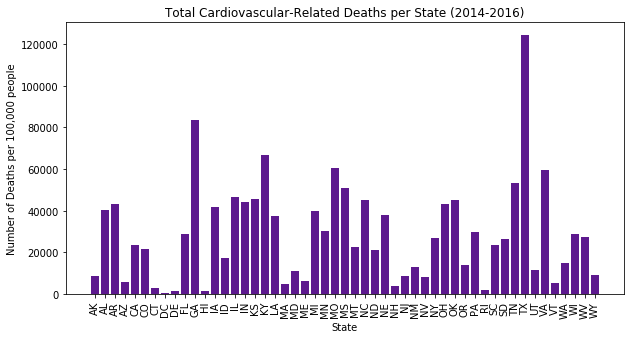

In [94]:
x_axis = np.arange(len(death_by_state))
tick_locations = [value for value in x_axis]
plt.figure(figsize=(10,5))
plt.bar(x_axis, death_by_state['Deaths'], color='indigo', alpha=0.9, align="center")
plt.xticks(tick_locations, death_by_state["State"], rotation="vertical")
plt.ylabel('Number of Deaths per 100,000 people')
plt.xlabel('State')
plt.title('Total Cardiovascular-Related Deaths per State (2014-2016)')

plt.savefig("SizeNational.png")
plt.show()

In [95]:
df_populations = pd.read_csv("Resources/State_Populations_2016.txt", encoding="UTF-16", sep='\t',header=0)
#df_populations.head()
data_frames2 = [df_merged, df_populations]
merge = reduce(lambda  left,right: pd.merge(left,right,on=['State'],
                                            how='outer'), data_frames2)

In [96]:
df_merge2 = merge.dropna(subset=['Population','Unemployment Rate', 'Deaths', 'Without Insurance'])
df_merged2 = df_merge2.sort_values(by='County')
df_merged2.head()

,County,State,Median Income,Unemployment Rate,Deaths,Without Insurance,Population
2317,Abbeville,SC,40.2,21.5,453.0,12.1,"4,961,119"
1155,Acadia,LA,40.2,22.4,599.7,13.0,"4,681,666"
2864,Accomack,VA,39.0,17.8,524.4,17.9,"8,411,808"
645,Ada,ID,61.6,5.3,364.9,8.9,"1,683,140"
1026,Adair,KY,33.9,23.1,570.5,7.2,"4,436,974"


In [97]:
#merged_median = df_merged2.groupby('County')
median_columns = df_merged2[['Median Income','Unemployment Rate','Without Insurance']].mean()
median_columns

Median Income        49.513186
Unemployment Rate    13.813538
Without Insurance    11.110249
dtype: float64

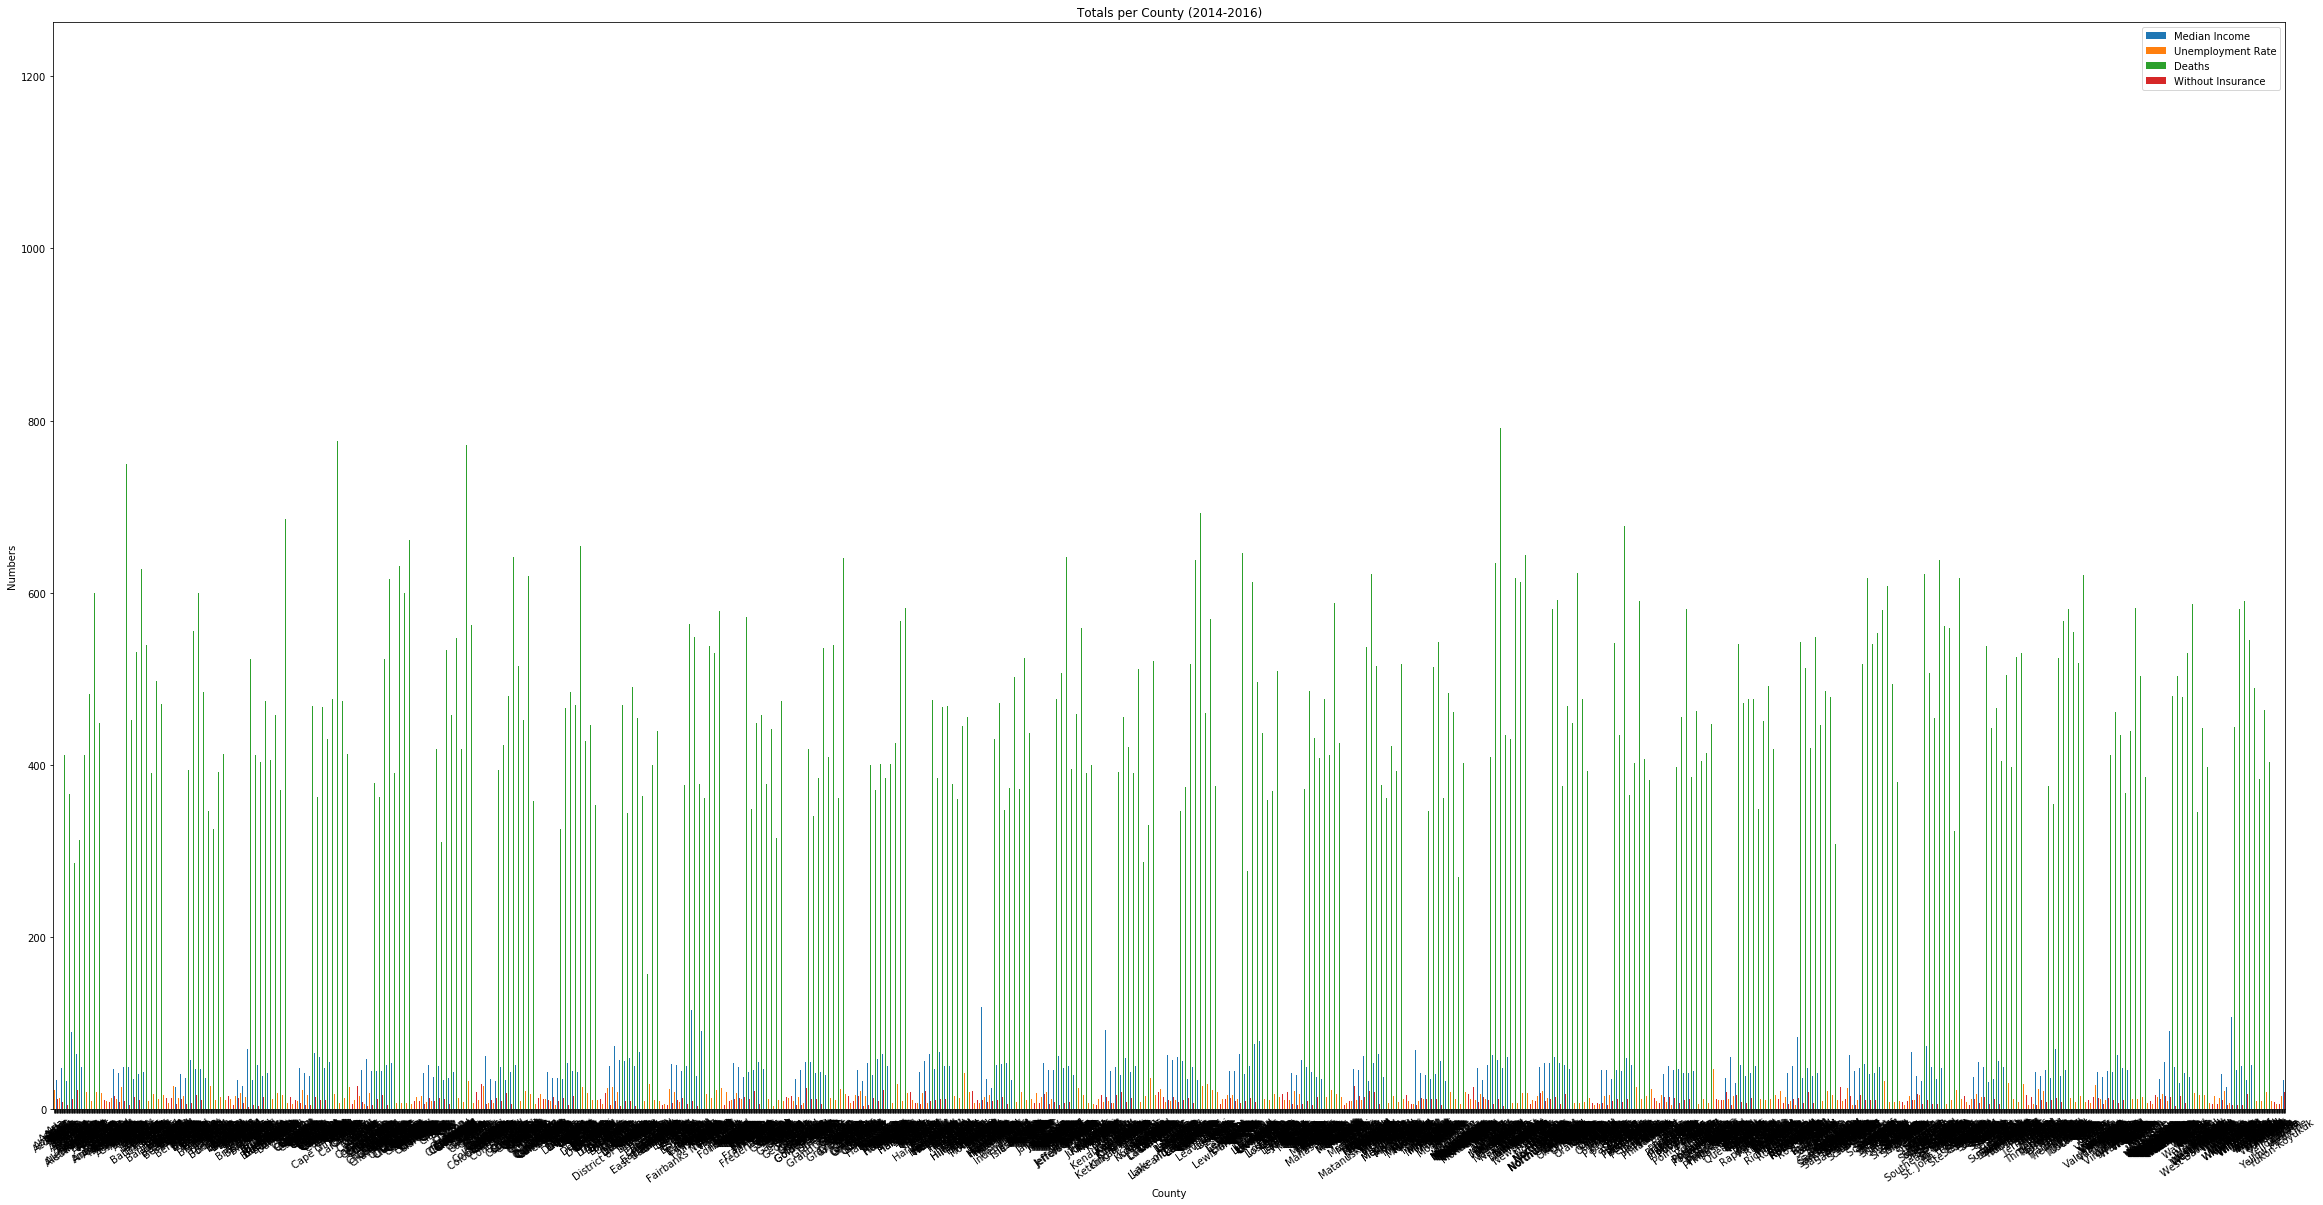

<Figure size 432x288 with 0 Axes>

In [73]:
multi_plot = df_merged2.plot(kind="bar", figsize=(40,20))

multi_plot.set_xticklabels(df_merged2["County"], rotation=35)
plt.ylabel('Numbers')
plt.xlabel('County')
plt.title('Totals per County (2014-2016)')
plt.savefig("Totalnumbers.png")
plt.show()
plt.tight_layout()

### Loading into SQL Database
#### We create a connection string to connect to PGAdmin Server. We checked the names of the tables in the database, just to be sure we created a new table name. Finally, we load the dataframe into the SQL database, where further analysis can be conducted. 

In [82]:
rds_connection_string = "postgres:postgres@localhost:5432/ETL_db"
engine = create_engine(f'postgresql://{rds_connection_string}')

In [84]:
engine.table_names()

[]

In [85]:
df_merged.to_sql(name='df_merged2', con=engine, if_exists='append', index=False)

#### Finally, we confirmed that the table had been loaded correctly, by doing a query of the table. The table appears to be loaded correctly. 

In [86]:
pd.read_sql_query('select * from df_merged2', con=engine).head()

,County,State,Median Income,Unemployment Rate,Deaths,Without Insurance
0,Kenai Peninsula,AK,68.5,7.4,415.8,17.9
1,Bethel,AK,46.6,19.8,480.6,23.9
2,Kodiak Island,AK,74.7,11.5,287.6,21.7
3,Anchorage,AK,84.0,6.6,346.2,12.9
4,Aleutians West,AK,78.2,11.7,184.7,22.3
